In [48]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from numba import jit, njit, int64, float64, boolean
import numpy.linalg as LA
import numpy.random as rando

In [49]:
@njit(float64[:](float64[:],float64,float64[:],float64,float64))
def TrapForce(r,q,trap,alpha,t):
    #Returns the trapping force on ion of charge q (with the x/y skewness defined by alpha from 0 to 1 (0.5 being symmetric))
    
    #Parameters:
    # r0 -- 1x3 np array, initial position vector
    # v0 -- 1x3 np array, initial velocity vector
    # trap -- np array of the form [omegaRF, VRF, VDC, r0, z0, kappa] ALL IN SI UNITS!!!
    # m -- mass of ion
    # q -- charge of ion

    #Returns
    # np.array(Fx,Fy,Fz) --- force on the ion
    x,y,z = np.copy(r)
    omega,VRF,VDC,r0,z0,kappa = np.copy(trap)
    Fz = -q*2*kappa*VDC/(z0**2) * z
    Fy = q*(2*(1-alpha)*kappa*VDC/(z0**2) *y -VRF/(r0**2)*y*np.cos(omega*t))
    Fx = q*(2*alpha*kappa*VDC/(z0**2) *x +VRF/(r0**2)*x*np.cos(omega*t))
    return  np.array([Fx,Fy,Fz])

@njit(float64[:](float64[:],float64,float64[:],float64,float64,float64))
def TickleForce(r,q,trap,Vtickle,freq,t):
    x,y,z = np.copy(r)
    omega,VRF,VDC,r0,z0,kappa = np.copy(trap)
    VTick = Vtickle * np.cos(freq*t)
    Fz = -q*2*kappa*VTick/(z0**2) * z
    Fy = q*(2*(1-0.5)*kappa*VTick/(z0**2)) * y
    Fx = q*(2*0.5*kappa*VTick/(z0**2)) *x
    return np.array([Fx,Fy,Fz])


@njit(float64[:](float64[:],float64[:],float64,float64))
def CoulombForce(r1,r2,q1,q2):
    #Returns the coulomb force on charged particle at position vector r1 exerted by charged particle at position r2
    #Parameters:
    # r1 -- position of particle force is being enacted on.
    # r2 -- position of the other charged particle
    # q1 -- charge of particle 1
    # q2 -- charge of particle 2

    #Returns:
    # np.array(Fx,Fy,Fz) --- force on the ion
    epsilon0 = 8.85 * 1e-12
    k = q1*q2/(4* np.pi * epsilon0)
    rLen = np.sqrt(np.sum((r1-r2)**2))
    return k * (r1-r2) / (rLen**3)

@njit(nb.types.Tuple((float64[:],float64[:],float64[:],float64[:]))(float64[:],float64[:],float64[:],float64,float64,float64,float64,float64,float64))
def SingleIonMotion(r,v,trap,m,q,alpha,dt,t,tfinal):
    #Do velocity verlet integration to determine the motion of a single ion.

    #Parameters:
    # r0 -- 1x3 np array, initial position vector
    # v0 -- 1x3 np array, initial velocity vector
    # trap -- np array of the form [omegaRF, VRF, VDC, r0, z0, kappa] ALL IN SI UNITS!!!
    # m -- mass of ion
    # q -- charge of ion
    # alpha -- float form 0 to 1 representing xy field skewsness
    # dt -- timestep size
    # t -- current time

    #Returns:
    # xs -- x positions at timestamps according to ts
    # ys -- y positions at timestamps according to ts
    # zs -- z positions at timestamps according to ts
    # ts -- timestamps at which positions are recorded
    accelerationOld = TrapForce(r,q,trap,alpha,t) / m
    position = np.copy(r)
    velocity = np.copy(v)
    xs = []
    ys = []
    zs = []
    ts = []
    # vs = []


    count = 0
    while t <= tfinal:
        
        #Calculate changes to position and velocity
        
        dr = velocity*dt + 0.5 * accelerationOld * dt**2
        accelerationNew = TrapForce(position+dr,q,trap,alpha,t+dt) / m
        dv = 0.5 * (accelerationOld+accelerationNew) * dt

        #Perform updates:
        accelerationOld = accelerationNew



        if count % 20 == 0:
            xs.append(position[0])
            ys.append(position[1])
            zs.append(position[2])
            # vs = numbaStack(vs,v)
            ts.append(t)
        position += dr
        velocity += dv
        t+= dt
        count +=1
    return np.array(xs),np.array(ys),np.array(zs), np.array(ts)


def calculateNormalModes(trap,m1,q1,m2,q2,alpha):
    #returns the normal modes of two ions in a trap.
    epsilon0 = 8.85*1e-12
    
    #Calculate secular frequencies:
    omegaRF,VRF,VDC,r0,z0,kappa = np.copy(trap)
    omegaX1,omegaY1,omegaZ1 = secularFrequencies(trap,m1,q1,alpha)
    omegaX2,omegaY2,omegaZ2 = secularFrequencies(trap,m2,q2,alpha)
    
    #Calculate equilibrium positions
    zeq1 = (q2 * q1 / (4 * np.pi * epsilon0 * m1 * omegaZ1**2) * (1 / (1 + q1/q2)**2))**(1/3)
    zeq2 = -q1/q2 * zeq1
    deltaZ = zeq1-zeq2

    #Setup K matrix for finding new eigenmodes
    print(omegaZ1**2)
    K11 = omegaZ1**2 + q1*q2/(4*np.pi*epsilon0*m1) * (2/deltaZ**3)
    K12 = -q1*q2/(4*np.pi*epsilon0*np.sqrt(m1*m2)) * (2/deltaZ**3)
    K22 = omegaZ2**2 + q1*q2/(4*np.pi*epsilon0*m2) * (2/deltaZ**3)

    K33 = omegaX1**2 - q1*q2/(4*np.pi*epsilon0*m1) * (1/deltaZ**3)
    K34 = -0.5*K12
    K44 = omegaX2**2 - q1*q2/(4*np.pi*epsilon0*m2) * (1/deltaZ**3)

    K55 = omegaY1**2 - q1*q2/(4*np.pi*epsilon0*m1) * (1/deltaZ**3)
    K56 = K34
    K66 = omegaY2**2 - q1*q2/(4*np.pi*epsilon0*m2) * (1/deltaZ**3)

    KZ = np.array([[K11,K12],[K12,K22]])
    KX = np.array([[K33,K34],[K34,K44]])
    KY = np.array([[K55,K56],[K56,K66]])
    print(KX)





    #Solve eigenproblem for K-matrix
    zFrequencies, zVectors = LA.eig(KZ)
    xFrequencies, xVectors = LA.eig(KX)
    yFrequencies, yVectors = LA.eig(KY)
    print(xFrequencies, xVectors)
    print(yFrequencies, yVectors)
    print(zFrequencies, zVectors)
    freqXs = [0,0] #First entry is in-phase frequnecy, 2nd entry is out-of-phase frequency
    freqYs = [0,0]
    freqZs =[0,0]


    finalXVec = [0,0]
    finalYVec = [0,0]
    finalZVec = [0,0]



    #Sort / name the different eigenvectors
    for vectorset,sortedFreqs,unsortedFreqs,sortedVecs in zip([xVectors,yVectors,zVectors],[freqXs,freqYs,freqZs],[xFrequencies,yFrequencies,zFrequencies],\
                                                   [finalXVec,finalYVec,finalZVec]):
        if np.sign(vectorset[0,0]) == np.sign (vectorset[1,0]): #is vector in-phase?
            sortedFreqs[0] = np.sqrt(unsortedFreqs[0])
            sortedFreqs[1] = np.sqrt(unsortedFreqs[1])
            sortedVecs[0] = vectorset[:,0]
            sortedVecs[1] = vectorset[:,1]
        else:
            sortedFreqs[0] = np.sqrt(unsortedFreqs[1])
            sortedFreqs[1] = np.sqrt(unsortedFreqs[0])
            sortedVecs[0] = vectorset[:,1]
            sortedVecs[1] = vectorset[:,0]
    #print('Frequency listing from secularMode func: ',np.array(freqXs)*1e-3/(2*np.pi),np.array(freqYs)/(2*np.pi)*1e-3,np.array(freqZs)/(2*np.pi)*1e-3)
    return np.array(freqXs),np.array(freqYs),np.array(freqZs),finalXVec,finalYVec,finalZVec

@njit(float64(float64[:],float64,float64))
def aParameter(trap,m,q):
    #calculates the trapping a parameter of an ion
    #parameters:
    # trap -- np array of the form [omegaRF, VRF, VDC, r0, z0, kappa] ALL IN SI UNITS!!!
    # m -- mass of ion
    # q -- charge of ion
    omegaRF,VRF,VDC,r0,z0,kappa = np.copy(trap)
    return (-4*q*kappa*VDC)/(m*z0**2*omegaRF**2)

@njit(float64(float64[:],float64,float64))
def qParameter(trap,m,q):
    #calculates the trapping q paramater of an ion
    #parameters:
    # trap -- np array of the form [omegaRF, VRF, VDC, r0, z0, kappa] ALL IN SI UNITS!!!
    # m -- mass of ion
    # q -- charge of ion

    #returns:
    # -- q parameter of the ion
    omegaRF,VRF,VDC,r0,z0,kappa = np.copy(trap)
    return (2*q*VRF)/(m*r0**2*omegaRF**2)

@njit(float64[:](float64[:],float64,float64,float64))
def secularFrequencies(trap,m,q,alpha):
    #Returns the secular frequencies of an ion along the x,y,z directions
    #parameters:
    # trap -- np array of the form [omegaRF, VRF, VDC, r0, z0, kappa] ALL IN SI UNITS!!!
    # m -- mass of ion
    # q -- charge of ion
    # alpha -- skewness factor of E-field in x-y- plane. alpha = 0.5 gives symmetric field.
    
    #Returns:
    # omegaX -- frequency in x direction
    # omegaY -- --II-- in y direction
    # omegaZ -- --II-- in z direction
    aparam = aParameter(trap,m,q)
    omegaRF,VRF,VDC,r0,z0,kappa = np.copy(trap)
    omegaZ = omegaRF * np.sqrt(-aparam/2)
    omegaPond = q*VRF/(np.sqrt(2)*omegaRF*m*r0**2)
    omegaX = np.sqrt(omegaPond**2 - alpha*omegaZ**2)
    omegaY = np.sqrt(omegaPond**2 - (1-alpha)*omegaZ**2)
    return np.array([omegaX,omegaY,omegaZ])

@njit(nb.types.Tuple((float64[:],float64[:],float64[:],float64[:],float64[:],float64[:],float64[:]))(\
        float64[:], float64[:], float64[:], float64[:], float64[:],\
            float64, float64,float64,float64,\
                float64,float64,float64))
def TwoIonMotion_NoTickle(r1,v1,r2,v2,trap,m1,q1,m2,q2,alpha,dt,tfinal):
    #Do velocity verlet integration to determine the motion of two ions.

    #Parameters:
    # r1 -- 1x3 np array, initial position vector of ion 1
    # v1 -- 1x3 np array, initial velocity vector of ion 1
    # r2 -- 1x3 np array, initial position vector of ion 2
    # v2 -- 1x3 np array, initial velocity vector of ion 2
    # trap -- np array of the form [omegaRF, VRF, VDC, r0, z0, kappa] ALL IN SI UNITS!!!
    # m1 -- mass of ion 1
    # q1 -- charge of ion 1
    # m2 -- mass  of ion 2
    # q2 -- charge of ion 2
    # alpha -- float form 0 to 1 representing xy field skewsness
    # dt -- timestep size
    # t -- current time

    #Returns:
    # xs1 -- x positions of ion 1 at timestamps according to ts
    # ys1 -- y positions of ion 1 at timestamps according to ts
    # zs1 -- z positions of ion 1 at timestamps according to ts
    # xs2 -- x positions of ion 2 at timestamps according to ts
    # ys2 -- y positions of ion 2 at timestamps according to ts
    # zs2 -- z positions of ion 2 at timestamps according to ts
    # ts -- timestamps at which positions are recorded
    
    t = 0.0
    

    position1 = np.copy(r1)
    position2 = np.copy(r2)

    velocity1 = np.copy(v1)
    velocity2 = np.copy(v2)



    CoulombOld1 = CoulombForce(position1,position2,q1,q2)
    accelerationOld1 = (TrapForce(position1,q1,trap,alpha,t) + CoulombOld1)/m1

    accelerationOld2 = (TrapForce(position2,q2,trap,alpha,t) - CoulombOld1)/ m2
    x1s = []
    y1s = []
    z1s = []

    x2s = []
    y2s = []
    z2s = []
    ts = []

    count = 0
    while t <= tfinal:
        dr1 = velocity1 * dt + 0.5 * accelerationOld1 * dt**2
        dr2 = velocity2 * dt + 0.5 * accelerationOld2 * dt**2

        CoulombNew1 = CoulombForce(position1 + dr1, position2 + dr2, q1, q2)

        accelerationNew1 = TrapForce(position1 + dr1, q1, trap, alpha, t + dt)/m1 + CoulombNew1 / m1
        accelerationNew2 = TrapForce(position2 + dr2, q2, trap, alpha, t + dt)/ m2 - CoulombNew1 / m2
        dv1 = 0.5 * (accelerationOld1 + accelerationNew1) * dt
        dv2 = 0.5 * (accelerationOld2 + accelerationNew2) * dt

        # Perform updates
        accelerationOld1 = accelerationNew1
        accelerationOld2 = accelerationNew2

        if count % 100 == 0:
            x1s.append(position1[0])
            y1s.append(position1[1])
            z1s.append(position1[2])
            x2s.append(position2[0])
            y2s.append(position2[1])
            z2s.append(position2[2])

            ts.append(t)
        position1 += dr1
        position2 += dr2

        velocity1 += dv1
        velocity2 += dv2
        t += dt
        count += 1
    return np.array(x1s), np.array(y1s), np.array(z1s), np.array(x2s), np.array(y2s), np.array(z2s), np.array(ts)


@njit(float64[:]())
def randomUnitVector():
    u = rando.rand()
    v = rando.rand()
    phi = 2*np.pi*u
    theta = np.arccos(1-2*v)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.array([x,y,z])

    
@njit(nb.types.Tuple((float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:],int64[:]))(float64[:], float64[:], float64[:], float64[:], float64[:], float64, float64, float64, float64, float64, float64, float64, float64[:], float64, float64, float64))
def TwoIonMotion_LASERCOOLING(r1,v1,r2,v2,trap,m1,q1,m2,q2,alpha,gamma,s,kvec,Delta,dt,tfinal):
    #Do velocity verlet integration to determine the motion of two ions.

    #Parameters:
    # r1 -- 1x3 np array, initial position vector of ion 1
    # v1 -- 1x3 np array, initial velocity vector of ion 1
    # r2 -- 1x3 np array, initial position vector of ion 2
    # v2 -- 1x3 np array, initial velocity vector of ion 2
    # trap -- np array of the form [omegaRF, VRF, VDC, r0, z0, kappa] ALL IN SI UNITS!!!
    # m1 -- mass of ion 1
    # q1 -- charge of ion 1
    # m2 -- mass  of ion 2
    # q2 -- charge of ion 2
    # alpha -- float form 0 to 1 representing xy field skewsness
    # dt -- timestep size
    # t -- current time

    #Returns:
    # xs1 -- x positions of ion 1 at timestamps according to ts
    # ys1 -- y positions of ion 1 at timestamps according to ts
    # zs1 -- z positions of ion 1 at timestamps according to ts
    # xs2 -- x positions of ion 2 at timestamps according to ts
    # ys2 -- y positions of ion 2 at timestamps according to ts
    # zs2 -- z positions of ion 2 at timestamps according to ts
    # ts -- timestamps at which positions are recorded
    
    t = 0.0
    hbar = 1.05*1e-34

    position1 = np.copy(r1)
    position2 = np.copy(r2)

    velocity1 = np.copy(v1)
    velocity2 = np.copy(v2)
    print('Gamma -- kVec -- Delta', gamma, kvec, Delta)


    CoulombOld1 = CoulombForce(position1,position2,q1,q2)
    accelerationOld1 = (TrapForce(position1,q1,trap,alpha,t) + CoulombOld1)/m1

    accelerationOld2 = (TrapForce(position2,q2,trap,alpha,t) - CoulombOld1)/ m2
    x1s = []
    y1s = []
    z1s = []

    x2s = []
    y2s = []
    z2s = []
    states = []
    ts = []
    kLen = np.sqrt(np.sum(kvec**2))
    count = 0
    state = 0
    while t <= tfinal:
        dr1 = velocity1 * dt + 0.5 * accelerationOld1 * dt**2
        dr2 = velocity2 * dt + 0.5 * accelerationOld2 * dt**2

        CoulombNew1 = CoulombForce(position1 + dr1, position2 + dr2, q1, q2)

        accelerationNew1 = TrapForce(position1 + dr1, q1, trap, alpha, t + dt)/m1 + CoulombNew1 / m1
        accelerationNew2 = TrapForce(position2 + dr2, q2, trap, alpha, t + dt)/ m2 - CoulombNew1 / m2
        dv1 = 0.5 * (accelerationOld1 + accelerationNew1) * dt
        dv2 = 0.5 * (accelerationOld2 + accelerationNew2) * dt


        
        
        #Here comes laser cooling of ion1
        if state == 0:
            AbsorbChance = gamma * (s * 0.5 / (1 + 4*((Delta - np.sum(velocity1*kvec))/gamma)**2)) * dt
            RNDChance = rando.rand()
            if RNDChance < AbsorbChance: #Absorption
                dv1 += hbar* kvec / m1
                state = 1
        else:
            StimEmissChance = (s * 0.5 * gamma / (1 + 4*((Delta - np.sum(velocity1*kvec))/gamma)**2)) * dt
            SpontEmissChance = gamma * dt
            RNDChance = rando.rand()
            if RNDChance < SpontEmissChance:
                dv1 += randomUnitVector() * hbar* kLen / m1
                state = 0
            elif RNDChance < (SpontEmissChance+StimEmissChance):
                dv1 -= hbar* kvec / m1
                state = 0

            
        # Perform updates
        accelerationOld1 = accelerationNew1
        accelerationOld2 = accelerationNew2


        if count % 100 == 0:
            x1s.append(position1[0])
            y1s.append(position1[1])
            z1s.append(position1[2])
            x2s.append(position2[0])
            y2s.append(position2[1])
            z2s.append(position2[2])
            states.append(state)
            ts.append(t)
        position1 += dr1
        position2 += dr2

        velocity1 += dv1
        velocity2 += dv2
        t += dt
        count += 1
    return np.array(x1s), np.array(y1s), np.array(z1s), np.array(x2s), np.array(y2s), np.array(z2s), np.array(ts),np.array(states)

@njit(nb.types.Tuple((float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:],int64[:]))(float64[:], float64[:], float64[:], float64[:], float64[:], float64, float64, float64, float64, float64, float64, float64, float64[:], float64, float64, float64,float64,float64))
def TwoIonMotion_LASERCOOLING_TICKLE(r1,v1,r2,v2,trap,m1,q1,m2,q2,alpha,gamma,s,kvec,Delta,freq,U_Tickle,dt,tfinal):
    #Do velocity verlet integration to determine the motion of two ions.

    #Parameters:
    # r1 -- 1x3 np array, initial position vector of ion 1
    # v1 -- 1x3 np array, initial velocity vector of ion 1
    # r2 -- 1x3 np array, initial position vector of ion 2
    # v2 -- 1x3 np array, initial velocity vector of ion 2
    # trap -- np array of the form [omegaRF, VRF, VDC, r0, z0, kappa] ALL IN SI UNITS!!!
    # m1 -- mass of ion 1
    # q1 -- charge of ion 1
    # m2 -- mass  of ion 2
    # q2 -- charge of ion 2
    # alpha -- float form 0 to 1 representing xy field skewsness
    # dt -- timestep size
    # t -- current time

    #Returns:
    # xs1 -- x positions of ion 1 at timestamps according to ts
    # ys1 -- y positions of ion 1 at timestamps according to ts
    # zs1 -- z positions of ion 1 at timestamps according to ts
    # xs2 -- x positions of ion 2 at timestamps according to ts
    # ys2 -- y positions of ion 2 at timestamps according to ts
    # zs2 -- z positions of ion 2 at timestamps according to ts
    # ts -- timestamps at which positions are recorded
    
    t = 0.0
    hbar = 1.05*1e-34

    position1 = np.copy(r1)
    position2 = np.copy(r2)

    velocity1 = np.copy(v1)
    velocity2 = np.copy(v2)
    print('Gamma -- kVec -- Delta', gamma, kvec, Delta)


    CoulombOld1 = CoulombForce(position1,position2,q1,q2)
    accelerationOld1 = (TrapForce(position1,q1,trap,alpha,t) + CoulombOld1 + TickleForce(position1,q1,trap,U_Tickle,freq,t))/m1

    accelerationOld2 = (TrapForce(position2,q2,trap,alpha,t) - CoulombOld1 + TickleForce(position2,q2,trap,U_Tickle,freq,t))/ m2
    x1s = []
    y1s = []
    z1s = []

    x2s = []
    y2s = []
    z2s = []
    states = []
    ts = []
    kLen = np.sqrt(np.sum(kvec**2))
    count = 0
    state = 0
    while t <= tfinal:
        dr1 = velocity1 * dt + 0.5 * accelerationOld1 * dt**2
        dr2 = velocity2 * dt + 0.5 * accelerationOld2 * dt**2

        CoulombNew1 = CoulombForce(position1 + dr1, position2 + dr2, q1, q2)

        accelerationNew1 = TrapForce(position1 + dr1, q1, trap, alpha, t + dt)/m1 + CoulombNew1 / m1 + TickleForce(position1 + dr1,q1,trap,U_Tickle,freq,t+dt) / m1
        accelerationNew2 = TrapForce(position2 + dr2, q2, trap, alpha, t + dt)/ m2 - CoulombNew1 / m2 + TickleForce(position2 + dr2,q2,trap,U_Tickle,freq,t+dt) / m2
        dv1 = 0.5 * (accelerationOld1 + accelerationNew1) * dt
        dv2 = 0.5 * (accelerationOld2 + accelerationNew2) * dt


        
        
        #Here comes laser cooling of ion1
        if state == 0:
            AbsorbChance = gamma * (s * 0.5 / (1 + 4*((Delta - np.sum(velocity1*kvec))/gamma)**2)) * dt
            RNDChance = rando.rand()
            if RNDChance < AbsorbChance: #Absorption
                dv1 += hbar* kvec / m1
                state = 1
        else:
            StimEmissChance = (s * 0.5 * gamma / (1 + 4*((Delta - np.sum(velocity1*kvec))/gamma)**2)) * dt
            SpontEmissChance = gamma * dt
            RNDChance = rando.rand()
            if RNDChance < SpontEmissChance:
                dv1 += randomUnitVector() * hbar* kLen / m1
                state = 0
            elif RNDChance < (SpontEmissChance+StimEmissChance):
                dv1 -= hbar* kvec / m1
                state = 0

            
        # Perform updates
        accelerationOld1 = accelerationNew1
        accelerationOld2 = accelerationNew2


        if count % 100 == 0:
            x1s.append(position1[0])
            y1s.append(position1[1])
            z1s.append(position1[2])
            x2s.append(position2[0])
            y2s.append(position2[1])
            z2s.append(position2[2])
            states.append(state)
            ts.append(t)
        position1 += dr1
        position2 += dr2

        velocity1 += dv1
        velocity2 += dv2
        t += dt
        count += 1
    return np.array(x1s), np.array(y1s), np.array(z1s), np.array(x2s), np.array(y2s), np.array(z2s), np.array(ts),np.array(states)


def kineticEnergy2Temperature(K,dimension):
    kb = 1.38 * 1e-23
    return 2 / (dimension * kb) * K

In [50]:
"""
Testing single ion equations of motion
"""
trap_parameters = np.array([2*np.pi*5.2*1e6, 1000, 18,3/4*3.5*1e-3, 3/4*2.7*1e-3, 0.248])

amu = 1.66*1e-27
charge = 1.6*1e-19

massBa = 135*amu
chargeBa = 1 *charge

rInit = np.array([1e-6,2e-6,-4e-6])
vInit = np.array([0.0,0.0,0.0])
solx,soly,solz,solts = SingleIonMotion(rInit,vInit,trap_parameters,massBa,chargeBa,0.1,1e-10,0,1e-4)

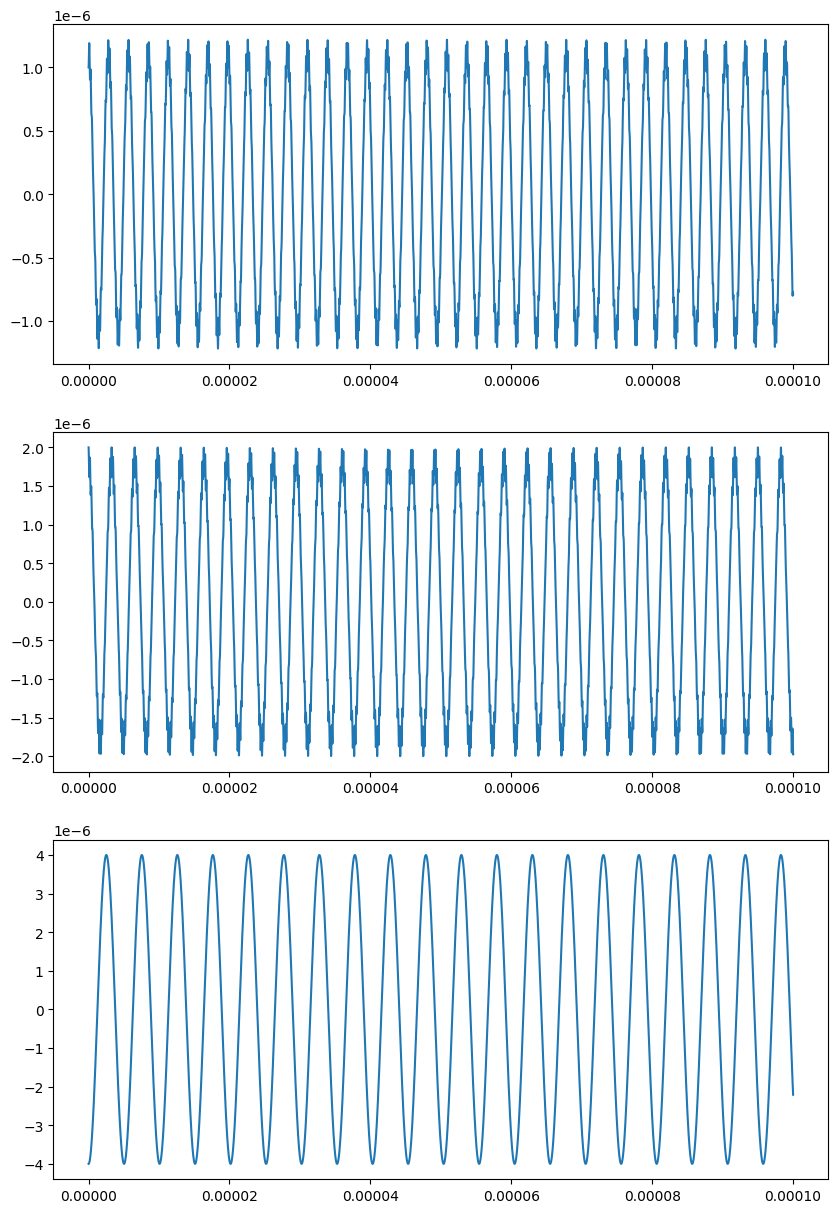

In [51]:
fig,ax = plt.subplots(3,1,figsize = (10,15))

ax[0].plot(solts,solx)
ax[1].plot(solts,soly)
ax[2].plot(solts,solz)

In [52]:
"""
Testing two ion equations of motion, without any laser cooling or coupling
"""



#define mass and charge of test ion
massTest = 135 * amu
chargeTest = 1 * charge
#calculate equilibrium position:
epsilon0 = 8.85 * 1e-12

kappa = trap_parameters[5]
VDC = trap_parameters[2]
z0 = trap_parameters[4]


omegaZsquare = 2 * chargeBa * kappa * VDC / (massBa * z0**2)

z1eq = (chargeTest * chargeBa / (4 * np.pi * epsilon0 * massBa * omegaZsquare) * (1 / (1 + chargeBa/chargeTest)**2))**(1/3)

z2eq = -chargeBa/chargeTest * z1eq


ALPHA = 0.3

freqX,freqY,freqZ,vecX,vecY,vecZ = calculateNormalModes(trap_parameters,massBa,chargeBa,massTest,chargeTest,ALPHA)
x1_init = 1e-5*vecX[0][0]/np.sqrt(massBa/amu)+1e-5*vecX[1][0]/np.sqrt(massBa/amu)
x2_init = 1e-5*vecX[0][1]/np.sqrt(massTest/amu)+1e-5*vecX[1][1]/np.sqrt(massTest/amu)


y1_init = 1e-5*vecY[0][0]/np.sqrt(massBa/amu)+1e-5*vecY[1][0]/np.sqrt(massBa/amu)
y2_init = 1e-5*vecY[0][1]/np.sqrt(massTest/amu)+1e-5*vecY[1][1]/np.sqrt(massTest/amu)

z1_init = z1eq+1e-5*vecZ[0][0]/np.sqrt(massBa/amu)+1e-5*vecZ[1][0]/(np.sqrt(massBa/amu))
z2_init = -z1eq+1e-5*vecZ[0][1]/np.sqrt(massTest/amu)+1e-5*vecZ[1][1]/(np.sqrt(massTest/amu))




# print('Equilibrium z-position is:', z1eq)
# print('frequencies: ',freqX*1e-3/(2*np.pi),freqY*1e-3/(2*np.pi),freqZ*1e-3/(2*np.pi))
# print('secular frequencies: ',secularFrequencies(trap_parameters,massBa,chargeBa,0.3)*1e-3 / (2*np.pi))
r1Init = np.array([x1_init,y1_init,z1_init])
r2Init = np.array([x2_init,y2_init,z2_init])
v1Init = np.array([0.0,0.0,0.0])
v2Init = v1Init
print('Equilibrium positions', z1eq*1e6,z2eq*1e6)
print('Eigenvectors:', vecX,vecY,vecZ)
print('Frequencies: ', freqX/(2*np.pi)*1e-3,freqY/(2*np.pi)*1e-3,freqZ/(2*np.pi)*1e-3)
print('Secular: ', secularFrequencies(trap_parameters,massBa,chargeBa,ALPHA)/(2*np.pi)*1e-3)
solx1,soly1,solz1,solx2,soly2,solz2,soltsTWO = TwoIonMotion_NoTickle(r1Init,v1Init,r2Init,v2Init,trap_parameters,\
                                                                    massBa,chargeBa,massTest,chargeTest,ALPHA,1e-10,1*1e-3)





1554469669563.7903
[[3.78497228e+12 7.77234835e+11]
 [7.77234835e+11 3.78497228e+12]]
[4.56220712e+12 3.00773745e+12] [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[3.94041925e+12 2.38594958e+12] [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[4.66340901e+12 1.55446967e+12] [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
Equilibrium positions 5.486990943447822 -5.486990943447822
Eigenvectors: [array([0.70710678, 0.70710678]), array([-0.70710678,  0.70710678])] [array([0.70710678, 0.70710678]), array([-0.70710678,  0.70710678])] [array([0.70710678, 0.70710678]), array([ 0.70710678, -0.70710678])]
Frequencies:  [339.94419585 276.01970867] [315.93034929 245.83898977] [198.43179361 343.69394836]
Secular:  [339.94419585 315.93034929 198.43179361]


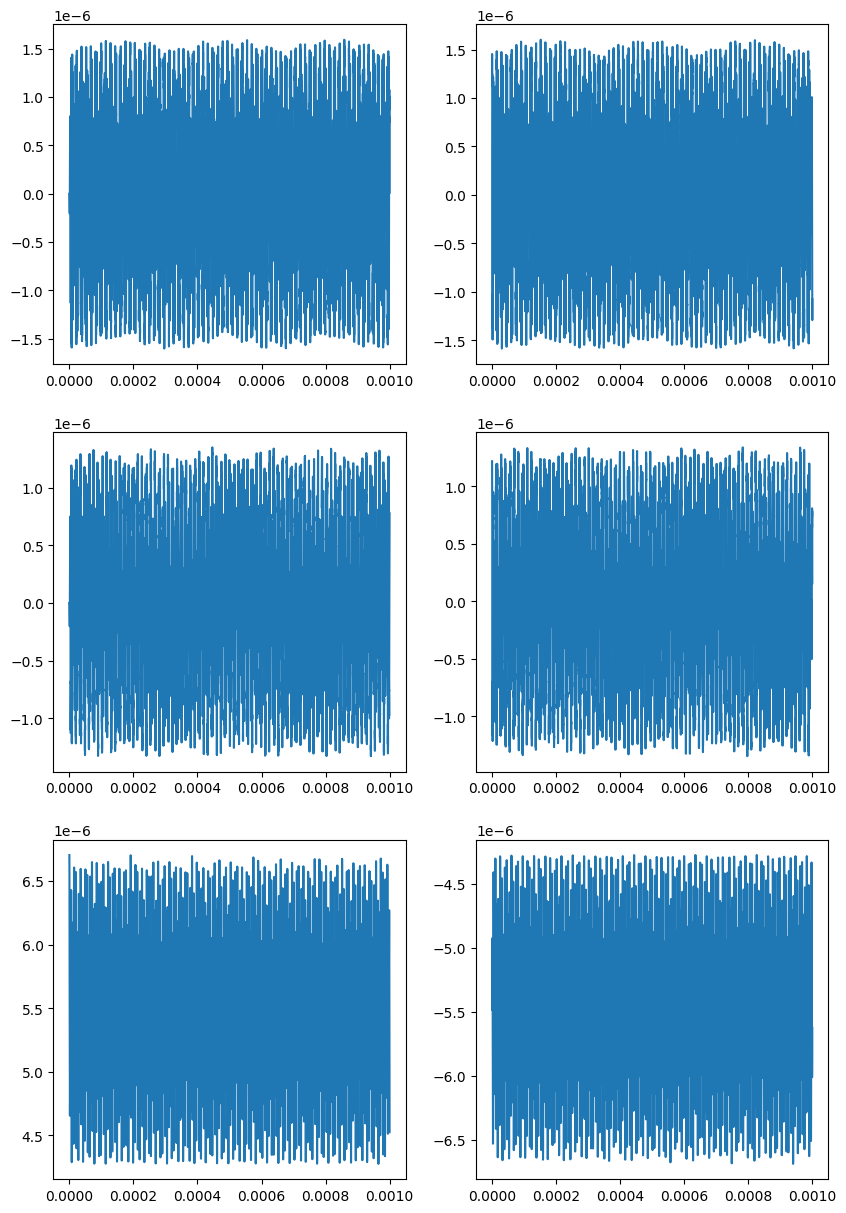

In [53]:
fig,ax = plt.subplots(3,2,figsize = (10,15))
ax[0,0].plot(soltsTWO,solx1)
ax[1,0].plot(soltsTWO,soly1)
ax[2,0].plot(soltsTWO,solz1)

ax[0,1].plot(soltsTWO,solx2)
ax[1,1].plot(soltsTWO,soly2)
ax[2,1].plot(soltsTWO,solz2)


np.savetxt('NewSimXs.txt',solx1)
np.savetxt('NewSimTs.txt',soltsTWO)

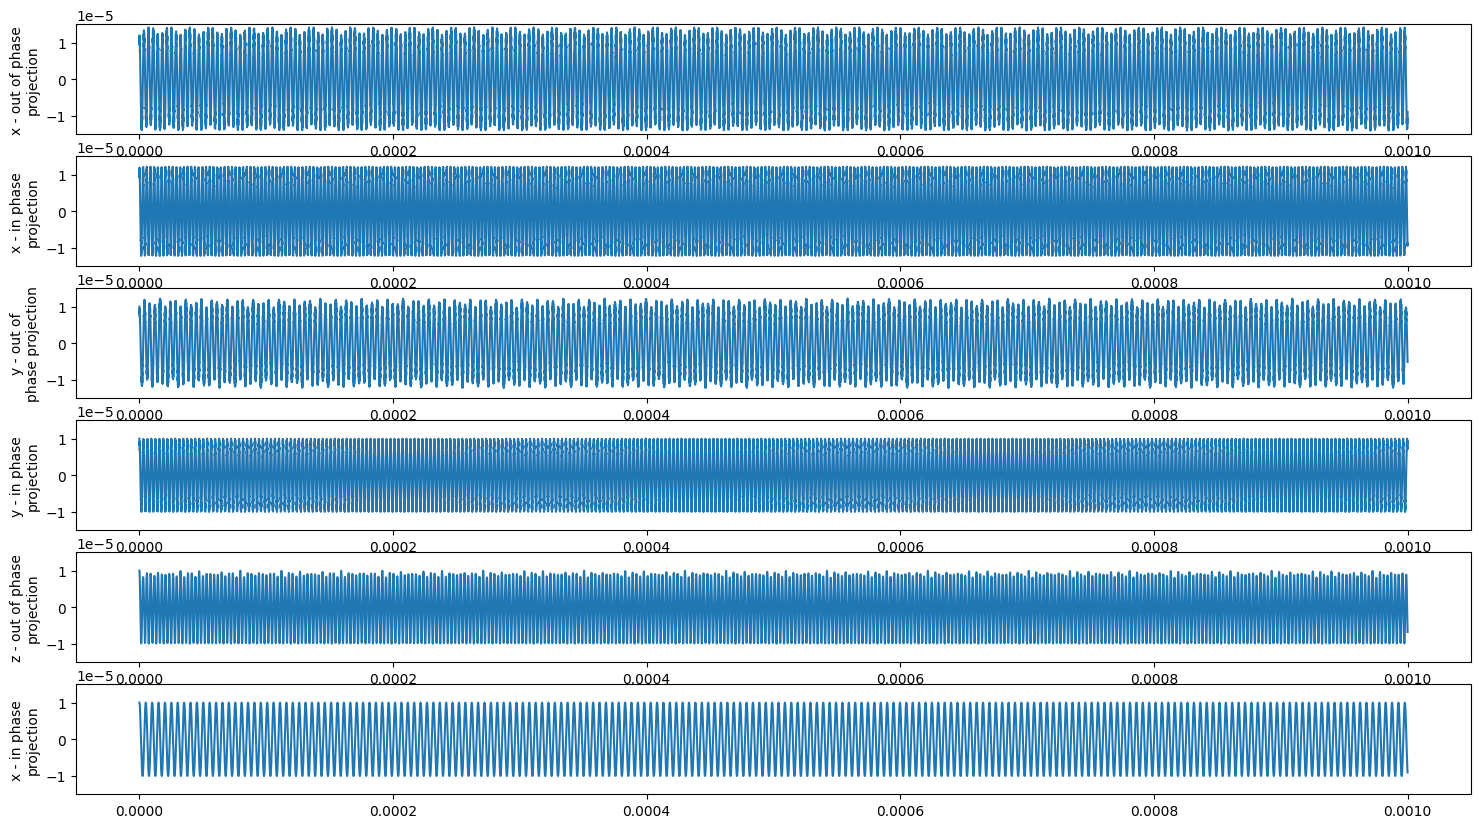

In [54]:
projXIn = np.zeros(len(solx1))
projXOut = np.zeros(len(solx1)) 
for j,x1,x2 in zip(range(len(solx1)),solx1,solx2):
    xVec = np.array([x1*np.sqrt(massBa/amu),x2*np.sqrt(massTest/amu)])
    projXIn[j] = np.dot(xVec,vecX[0])
    projXOut[j] = np.dot(xVec,vecX[1])

projYIn = np.zeros(len(solx1))
projYOut = np.zeros(len(solx1)) 
for j,y1,y2 in zip(range(len(solx1)),soly1,soly2):
    yVec = np.array([y1*np.sqrt(massBa/amu),y2*np.sqrt(massTest/amu)])
    projYIn[j] = np.dot(yVec,vecY[0])
    projYOut[j] = np.dot(yVec,vecY[1])

projZIn = np.zeros(len(solx1))
projZOut = np.zeros(len(solx1)) 
for j,z1,z2 in zip(range(len(solz1)),solz1,solz2):
    zVec = np.array([(z1-z1eq)*np.sqrt(massBa/amu),(z2-z2eq)*np.sqrt(massTest/amu)])
    projZIn[j] = np.dot(zVec,vecZ[0])
    projZOut[j] = np.dot(zVec,vecZ[1])

fig,ax = plt.subplots(6,1,figsize = (18,10))
ax[1].plot(soltsTWO,projXIn)
ax[0].plot(soltsTWO,projXOut)

ax[3].plot(soltsTWO,projYIn)
ax[2].plot(soltsTWO,projYOut)

ax[5].plot(soltsTWO,projZIn)
ax[4].plot(soltsTWO,projZOut)
for axe in ax:
    axe.set_ylim(1.5*(-1e-5),1.5*1e-5)
ax[0].set_ylabel('x - out of phase\nprojection')
ax[1].set_ylabel('x - in phase\nprojection')
ax[2].set_ylabel('y - out of\nphase projection')
ax[3].set_ylabel('y - in phase\nprojection')
ax[4].set_ylabel('z - out of phase\nprojection')
ax[5].set_ylabel('x - in phase\nprojection')


np.savetxt('NewSimXOut.txt',projXOut)

[1.e-08 1.e-08 1.e-08 ... 1.e-08 1.e-08 1.e-08]
[339.94419585 276.01970867] [315.93034929 245.83898977] [198.43179361 343.69394836]
[2135932.37661029 1734282.97803106 1985048.92877394 1544651.92844951]
15


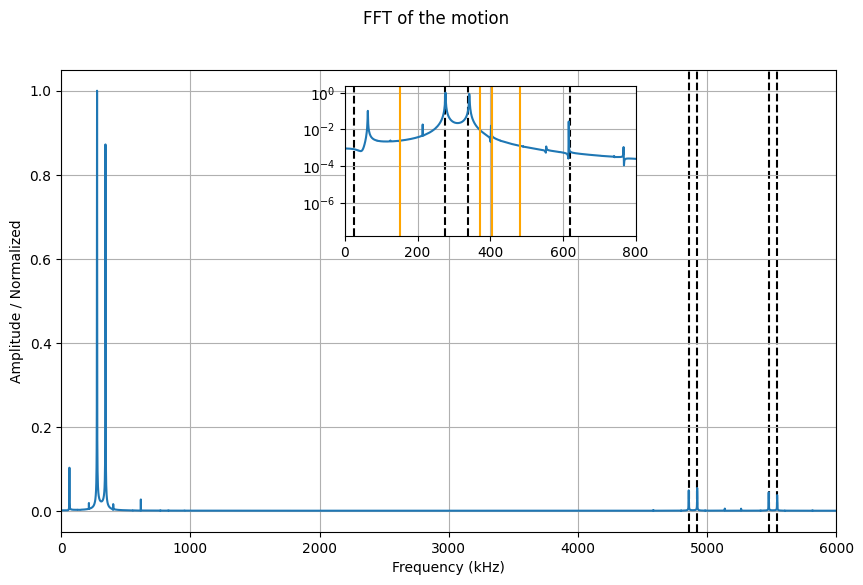

In [55]:
"""As a diagnostic, perform an fft of the motion to determine which frequencies are present:"""
from scipy.fft import fft, fftfreq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
print(np.diff(soltsTWO))

# Assuming X is your data array and T is the time spacing
N = len(solx1)  # Number of data points
T = np.diff(soltsTWO)[0] #Data spacing

# Compute the FFT
X1_fft = fft(solx1)
# Compute the frequencies
frequencies = fftfreq(N, T)

# Only take the positive frequencies
positive_frequencies = frequencies[:N//2]
positive_X_fft = 2.0/N * np.abs(X1_fft[:N//2])

# Plot the FFT result
fig,ax = plt.subplots(figsize=(10, 6))
ax.plot(positive_frequencies*1e-3, positive_X_fft/np.max(positive_X_fft))
fig.suptitle('FFT of the motion')
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Amplitude / Normalized')
ax.grid()
ax.set_xlim(0,6*1e3)
# Create an inset of the plot

# Create inset of the plot
ax_inset = inset_axes(plt.gca(), width="50%", height="50%", loc='upper right',bbox_to_anchor=(0, 0.33, 0.75, 0.65),bbox_transform=plt.gca().transAxes)
ax_inset.plot(positive_frequencies*1e-3, positive_X_fft/np.max(positive_X_fft))
ax_inset.set_xlim(0, 800)
ax_inset.grid()
ax_inset.axvline(freqX[0]/(2*np.pi)*1e-3, ls = '--', color = 'k',zorder = -20)
ax_inset.axvline(freqX[1]/(2*np.pi)*1e-3, ls = '--', color = 'k',zorder = -20)
ax_inset.axvline(freqX[0]/(2*np.pi)*1e-3-freqY[0]/(2*np.pi)*1e-3, ls = '--', zorder = -20,color = 'k')
ax_inset.axvline((freqX[1]+freqZ[1])/(2*np.pi)*1e-3, ls = '--', zorder = -20,color = 'k')


print(freqX/(2*np.pi)*1e-3,freqY/(2*np.pi)*1e-3,freqZ/(2*np.pi)*1e-3)
print(np.hstack((freqX,freqY)))#+freqZ)
ALLFrequencies = np.hstack((np.hstack((freqX,freqY)),freqZ))


def possible_sums(X):
    sums = []
    n = len(X)
    for i in range(n):
        for j in range(n):
            sums.append(2*X[i] + X[j])
    return sums
def possible_diffs(X):
    diffs = []
    n = len(X)
    for i in range(n):
        for j in range(n):
            if X[i] - X[j] > 0:
                diffs.append(2*X[i] - X[j])
    return diffs

def generate_colors(N):
    """
    Generate a list of N distinct colors.

    Parameters:
    N (int): Number of colors to generate.

    Returns:
    list: List of colors.
    """
    # Use a colormap to generate colors
    colors = plt.cm.tab20(np.linspace(0, 1, N))
    return colors
ALLSums = possible_sums(ALLFrequencies)
colorlist = generate_colors(len(ALLSums))

ALLDIffs = possible_diffs(ALLFrequencies)
print(len(ALLDIffs))
ax_inset.axvline(ALLDIffs[0]*1e-3/(2*np.pi),color = 'orange')
ax_inset.axvline(ALLDIffs[3]*1e-3/(2*np.pi),color = 'orange')
ax_inset.axvline(ALLDIffs[12]*1e-3/(2*np.pi),color = 'orange')
ax_inset.axvline((2*freqZ[0]-freqY[1])*1e-3/(2*np.pi),color = 'orange')






vline_labels = [f'Line {i+1}' for i in range(len(ALLSums))]

# for sum, label, color in zip(ALLDIffs, vline_labels, colorlist):
#     ax_inset.axvline(sum*1e-3/(2*np.pi), label=label, color=color)
# # for sum in ALLSums:
# #     ax_inset.axvline(sum*1e-3/(2*np.pi))



omegaRF = 5.2*1e6 * 2*np.pi
ax.axvline(omegaRF*1e-3/(2*np.pi) + freqX[0]/(2*np.pi)*1e-3, ls = '--', color = 'k',zorder = -20)
ax.axvline(omegaRF*1e-3/(2*np.pi) - freqX[0]/(2*np.pi)*1e-3, ls = '--', color = 'k',zorder = -20)
ax.axvline(omegaRF*1e-3/(2*np.pi) + freqX[1]/(2*np.pi)*1e-3, ls = '--', color = 'k',zorder = -20)
ax.axvline(omegaRF*1e-3/(2*np.pi) - freqX[1]/(2*np.pi)*1e-3, ls = '--', color = 'k',zorder = -20)
ax_inset.set_yscale('log')


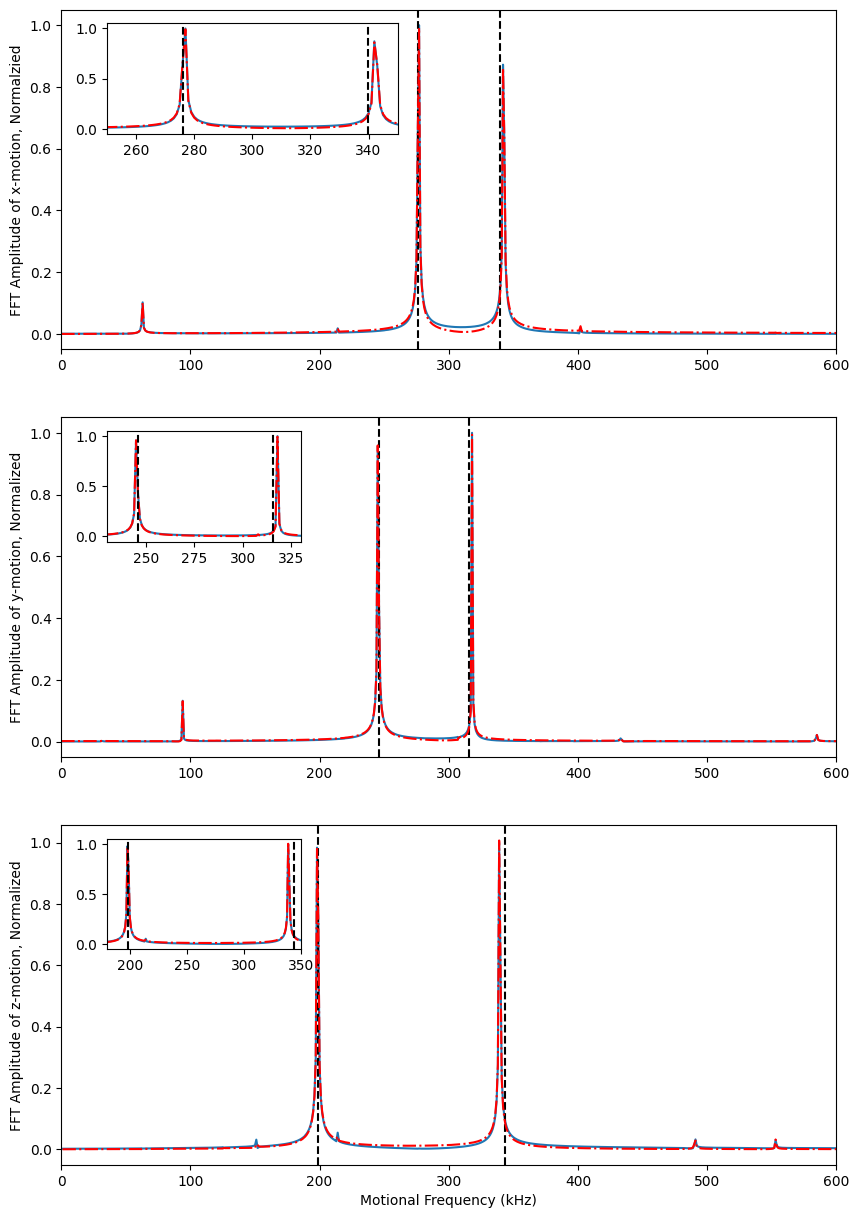

In [ ]:
from scipy.signal import find_peaks

N = len(solx1)
T = np.diff(soltsTWO)[0]
X1FFT = fft(solx1)
X2FFT = fft(solx2)

Y1FFT = fft(soly1)
Y2FFT = fft(soly2)

Z1FFT = fft(solz1)
Z2FFT = fft(solz2)

frequencies = fftfreq(N,T)

positive_frequencies = frequencies[:N//2]

fig,ax = plt.subplots(3,1,figsize = (10,15))
ax[0].plot(positive_frequencies*1e-3,np.abs(X1FFT[:N//2])/np.max(np.abs(X1FFT[:N//2])))
ax[0].set_xlim(0,600)
ax[0].axvline(freqX[0]/(2*np.pi*1e3),color = 'k', ls = '--')
ax[0].axvline(freqX[1]/(2*np.pi*1e3),color = 'k', ls = '--')
ax[0].plot(positive_frequencies*1e-3,np.abs(X2FFT[:N//2])/np.max(np.abs(X1FFT[:N//2])), ls = '-.',color = 'red')

ax[0].set_ylabel('FFT Amplitude of x-motion, Normalzied')
ax_inset = inset_axes(ax[0], width="50%", height="50%", loc='upper left',bbox_to_anchor=(0.05, 0.33, 0.75, 0.65),bbox_transform=ax[0].transAxes)
ax_inset.plot(positive_frequencies*1e-3,np.abs(X1FFT[:N//2])/np.max(np.abs(X1FFT[:N//2])))
ax_inset.plot(positive_frequencies*1e-3,np.abs(X2FFT[:N//2])/np.max(np.abs(X1FFT[:N//2])), ls = '-.',color = 'red')
ax_inset.set_xlim(250, 350)
ax_inset.axvline(freqX[0]/(2*np.pi*1e3),color = 'k', ls = '--')
ax_inset.axvline(freqX[1]/(2*np.pi*1e3),color = 'k', ls = '--')




ax[1].plot(positive_frequencies*1e-3,np.abs(Y1FFT[:N//2])/np.max(np.abs(Y1FFT[:N//2])))
ax[1].set_xlim(0,600)
ax[1].axvline(freqY[0]/(2*np.pi*1e3),color = 'k', ls = '--')
ax[1].axvline(freqY[1]/(2*np.pi*1e3),color = 'k', ls = '--')
ax[1].plot(positive_frequencies*1e-3,np.abs(Y2FFT[:N//2])/np.max(np.abs(Y1FFT[:N//2])), ls = '-.',color = 'red')

ax[1].set_ylabel('FFT Amplitude of y-motion, Normalized')
ax_inset2 = inset_axes(ax[1], width="50%", height="50%", loc='upper left',bbox_to_anchor=(0.05, 0.33, 0.5, 0.65),bbox_transform=ax[1].transAxes)
ax_inset2.plot(positive_frequencies*1e-3,np.abs(Y1FFT[:N//2])/np.max(np.abs(Y1FFT[:N//2])))
ax_inset2.plot(positive_frequencies*1e-3,np.abs(Y2FFT[:N//2])/np.max(np.abs(Y1FFT[:N//2])), ls = '-.',color = 'red')
ax_inset2.set_xlim(230, 330)
ax_inset2.axvline(freqY[0]/(2*np.pi*1e3),color = 'k', ls = '--')
ax_inset2.axvline(freqY[1]/(2*np.pi*1e3),color = 'k', ls = '--')

ax[2].plot(positive_frequencies[1:]*1e-3,np.abs(Z1FFT[1:N//2])/np.max(np.abs(Z1FFT[1:N//2])))
ax[2].set_xlim(0,600)
ax[2].axvline(freqZ[0]/(2*np.pi*1e3),color = 'k', ls = '--')
ax[2].axvline(freqZ[1]/(2*np.pi*1e3),color = 'k', ls = '--')
ax[2].plot(positive_frequencies[1:]*1e-3,np.abs(Z2FFT[1:N//2])/np.max(np.abs(Z1FFT[1:N//2])), ls = '-.',color = 'red')
ax[2].set_ylabel('FFT Amplitude of z-motion, Normalized')
ax_inset3 = inset_axes(ax[2], width="50%", height="50%", loc='upper left',bbox_to_anchor=(0.05, 0.33, 0.5, 0.65),bbox_transform=ax[2].transAxes)
ax_inset3.plot(positive_frequencies[1:]*1e-3,np.abs(Z1FFT[1:N//2])/np.max(np.abs(Z1FFT[1:N//2])))
ax_inset3.plot(positive_frequencies[1:]*1e-3,np.abs(Z2FFT[1:N//2])/np.max(np.abs(Z1FFT[1:N//2])), ls = '-.',color = 'red')
ax_inset3.set_xlim(180, 350)
ax_inset3.axvline(freqZ[0]/(2*np.pi*1e3),color = 'k', ls = '--')
ax_inset3.axvline(freqZ[1]/(2*np.pi*1e3),color = 'k', ls = '--')

ax[2].set_xlabel('Motional Frequency (kHz)')

def find_peaks(X,n):
    #Returns the indexes for the n highest values in X:
    idxs = []
    dataSet = np.copy(X)
    for i in range(n):
        idx = np.argmax(dataSet)
        idxs.append(idx)
        dataSet[idx] = 0 #or use pop
    return idxs

peakArgs = find_peaks(np.abs(Z1FFT[1:N//2]),2)
print([psotive_frequencies[peak] for peak in peakArgs])

In [40]:
"""Rudimentary calculation of kinetic energy of the ions:"""

VX1s = np.diff(solx1) / np.diff(soltsTWO)
VY1s = np.diff(soly1) / np.diff(soltsTWO)
VZ1 = np.diff(solz1) / np.diff(soltsTWO)

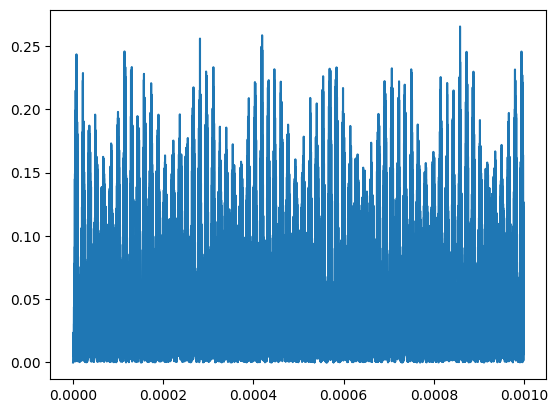

In [41]:
T1 = 1/2 * massBa * (VX1s**2+VY1s**2+VZ1**2)
fig,ax = plt.subplots()
temperature = [kineticEnergy2Temperature(T,3) for T in T1]
ax.plot(soltsTWO[:-1],temperature)

In [42]:
"""Add laser cooling of ions now!"""



GAMMA = 2*np.pi*15.2*1e6
c = 3*1e8
lambd = c/(607.426262*1e12)
k = 2*np.pi/lambd*np.array([1/2,1/2,1/np.sqrt(2)])
delta = -GAMMA / 2

print(GAMMA,delta, np.sqrt(np.sum(k**2)),k)



solx1,soly1,solz1,solx2,soly2,solz2,soltsTWO,states = TwoIonMotion_LASERCOOLING(r1Init,v1Init,r2Init,v2Init,trap_parameters,massBa,chargeBa,\
                                                                         massTest,chargeTest,ALPHA,GAMMA,0.1,k,delta,1e-10,10e-3)

95504416.66912971 -47752208.33456486 12721905.881978061 [6360952.94098903 6360952.94098903 8995745.91876371]
Gamma -- kVec -- Delta 95504416.66912971 [6360952.94098903 6360952.94098903 8995745.91876371] -47752208.33456486


Text(0.5, 0, 'Time / ms')

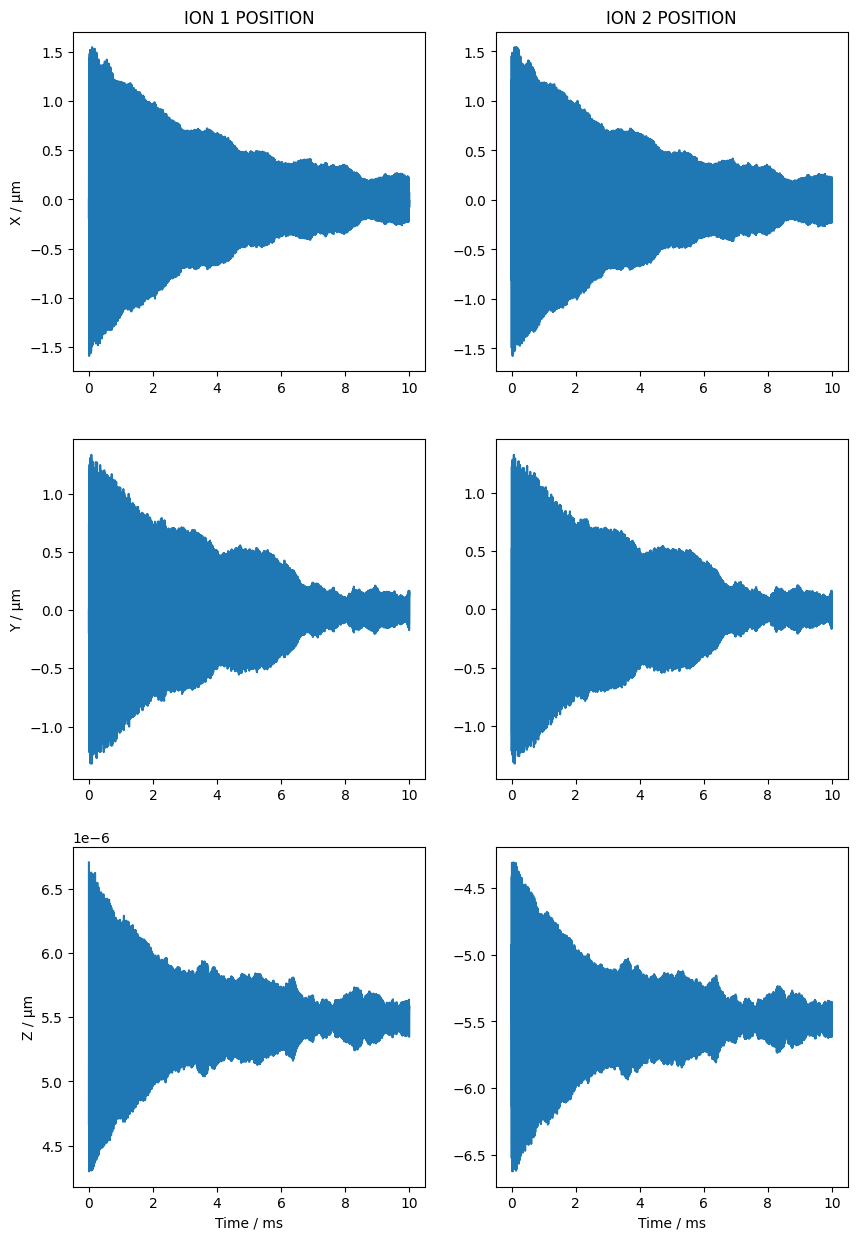

In [43]:
fig,ax = plt.subplots(3,2,figsize = (10,15))
ax[0,0].plot(soltsTWO*1e3,solx1*1e6)
ax[1,0].plot(soltsTWO*1e3,soly1*1e6)
ax[2,0].plot(soltsTWO*1e3,solz1)

ax[0,1].plot(soltsTWO*1e3,solx2*1e6)
ax[1,1].plot(soltsTWO*1e3,soly2*1e6)
ax[2,1].plot(soltsTWO*1e3,solz2*1e6)

ax[0,0].set_title('ION 1 POSITION')
ax[0,1].set_title('ION 2 POSITION')

ax[0,0].set_ylabel('X / µm')
ax[1,0].set_ylabel('Y / µm')
ax[2,0].set_ylabel('Z / µm')

ax[2,0].set_xlabel('Time / ms')
ax[2,1].set_xlabel ('Time / ms')
# np.savetxt('NewSimXs.txt',solx1)
# np.savetxt('NewSimTs.txt',soltsTWO)

In [44]:
""" We'd like to have some measure of the temperature. The classical equipartition theorem states that each quadratic
term should grant us a factor of 0.5 * kb * T. Thus the total kinetic energy over n dimensions should follow the rule K = n/2 * kb * T. This allows us to DEFINE
a temperature in each direction, as well as a total temperature. It should be noted that this is at best an approximation of the temperature.
"""

" We'd like to have some measure of the temperature. The classical equipartition theorem states that each quadratic\nterm should grant us a factor of 0.5 * kb * T. Thus the total kinetic energy over n dimensions should follow the rule K = n/2 * kb * T. This allows us to DEFINE\na temperature in each direction, as well as a total temperature. It should be noted that this is at best an approximation of the temperature.\n"

[array([1.82813340e-07, 1.66710276e-06, 4.73988169e-06, ...,
       5.42385961e-06, 3.45489268e-05, 2.45717933e-04]), array([1.81574328e-07, 1.61353852e-06, 4.38183712e-06, ...,
       2.28192956e-03, 9.85067854e-04, 1.31912005e-04]), array([5.59307360e-06, 5.03280132e-05, 1.39748621e-04, ...,
       8.80197098e-05, 9.44850589e-05, 1.01035421e-04])]


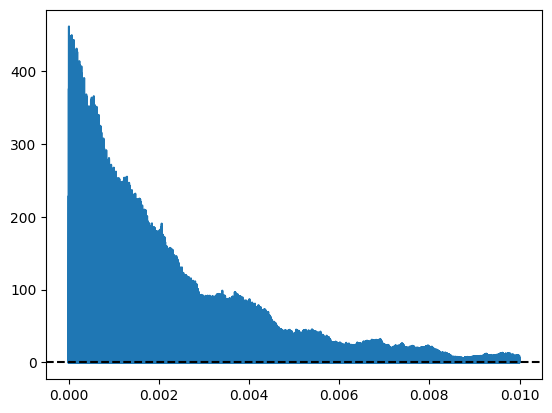

In [45]:
#Calcualte velocities using np.diff() / dt. This may be a little coarse. 

vx1 = np.diff(solx1)/np.diff(soltsTWO)
vx2 = np.diff(solx2)/np.diff(soltsTWO)
vy1 = np.diff(soly1)/np.diff(soltsTWO)
vy2 = np.diff(soly2)/np.diff(soltsTWO)
vz1 = np.diff(solz1)/np.diff(soltsTWO)
vz2 = np.diff(solz2)/np.diff(soltsTWO)

kineticEnergies1 = [0.5*massBa*v**2 for v in [vx1,vy1,vz1]]
kineticEnergies2 = [0.5*massTest*v**2 for v in [vx2,vy2,vz2]]

D1_Temperatures_1 = [kineticEnergy2Temperature(kin,1) for kin in kineticEnergies1]

print(D1_Temperatures_1)

fig,ax = plt.subplots()
ax.plot(soltsTWO[:-1],D1_Temperatures_1[0]*1e3)
ax.axhline(0.5, ls = '--', c = 'k')

In [46]:
"""Try to add tickle force to the ions"""
U_tickle = trap_parameters[2] * 0.1
freq_diff_Z = np.max(freqZ) - np.min(freqZ)
print(freq_diff_Z)
solx1,soly1,solz1,solx2,soly2,solz2,soltsTWO,states = TwoIonMotion_LASERCOOLING_TICKLE(r1Init,v1Init,r2Init,v2Init,trap_parameters,massBa,chargeBa,\
                                                                         massTest,chargeTest,ALPHA,GAMMA,0.1,k,delta,freq_diff_Z,U_tickle,1e-10,10e-3)

912709.0364604595
Gamma -- kVec -- Delta 95504416.66912971 [6360952.94098903 6360952.94098903 8995745.91876371] -47752208.33456486


Text(0.5, 0, 'Time / ms')

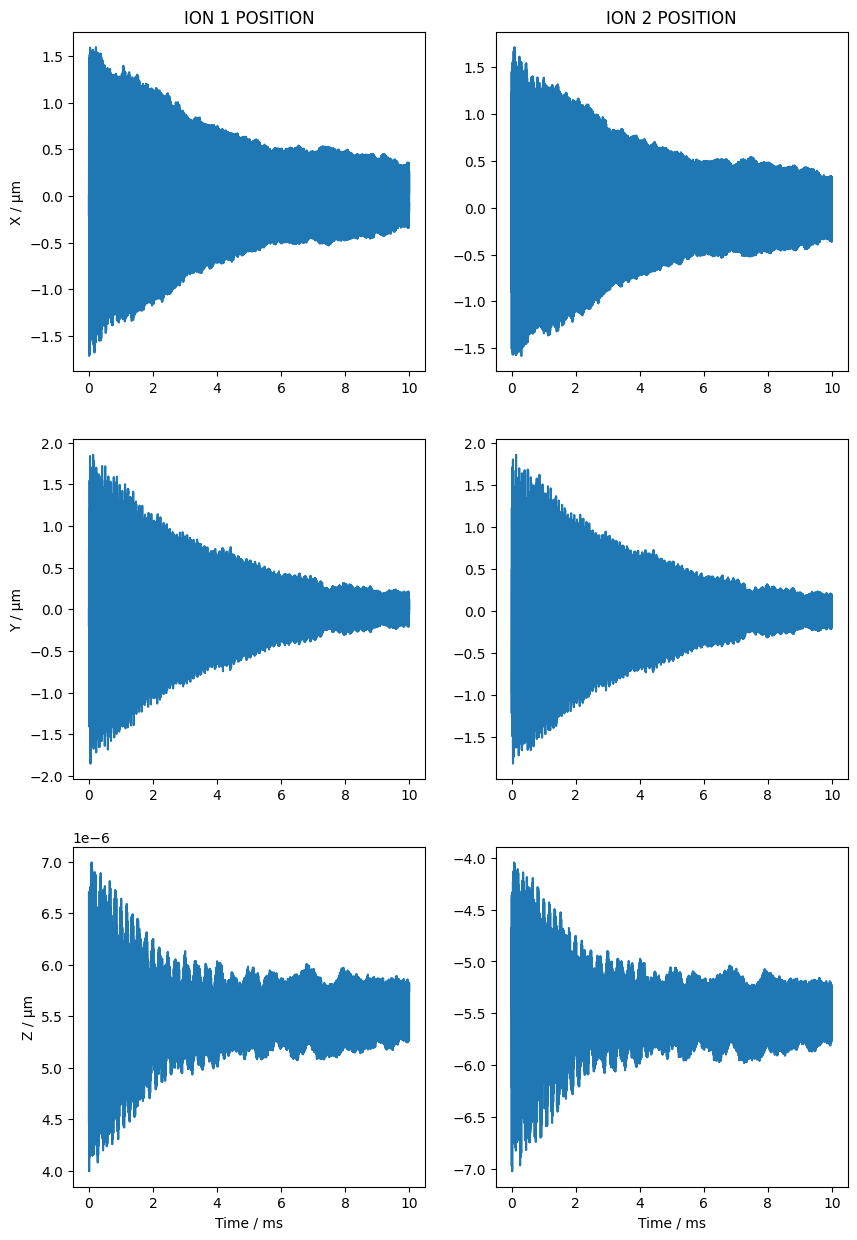

In [47]:
fig,ax = plt.subplots(3,2,figsize = (10,15))
ax[0,0].plot(soltsTWO*1e3,solx1*1e6)
ax[1,0].plot(soltsTWO*1e3,soly1*1e6)
ax[2,0].plot(soltsTWO*1e3,solz1)

ax[0,1].plot(soltsTWO*1e3,solx2*1e6)
ax[1,1].plot(soltsTWO*1e3,soly2*1e6)
ax[2,1].plot(soltsTWO*1e3,solz2*1e6)

ax[0,0].set_title('ION 1 POSITION')
ax[0,1].set_title('ION 2 POSITION')

ax[0,0].set_ylabel('X / µm')
ax[1,0].set_ylabel('Y / µm')
ax[2,0].set_ylabel('Z / µm')

ax[2,0].set_xlabel('Time / ms')
ax[2,1].set_xlabel ('Time / ms')